In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Load data
url = 'https://raw.githubusercontent.com/C4AnN/Models/data/dataset_processing%20(Model%20LR%202)/file_gabungan2.csv'
store_sales = pd.read_csv(url)
store_sales['date'] = pd.to_datetime(store_sales['date'])

# Categorize data based on price
def categorize_price(price):
    if price <= 8000000:
        return 'low'
    elif 8000000 < price <= 16000000:
        return 'mid'
    else:
        return 'high'

store_sales['category'] = store_sales['price'].apply(categorize_price)

# Drop unnecessary columns
store_sales = store_sales.drop(['name', 'price'], axis=1)

# Function to process and predict for each category
def process_category(data, category_name, window_size):
    data = data[data['category'] == category_name].drop(['category'], axis=1)
    data['date'] = data['date'].dt.to_period("M")
    monthly_sales = data.groupby('date').sum().reset_index()
    monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

    # Calculate sales difference
    monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
    monthly_sales = monthly_sales.dropna()

    # Prepare supervised data with a window size
    supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)
    for i in range(1, window_size + 1):
        col_name = 'month_' + str(i)
        supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
    supervised_data = supervised_data.dropna().reset_index(drop=True)

    # Split into train and test data
    train_data = supervised_data[:-24]
    test_data = supervised_data[-12:]

    # Scale the data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(train_data)
    train_data_scaled = scaler.transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    X_train, y_train = train_data_scaled[:, 1:], train_data_scaled[:, 0]
    X_test, y_test = test_data_scaled[:, 1:], test_data_scaled[:, 0]

    # Reshape input to be 3D [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build LSTM model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(LSTM(200, activation='tanh', return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(100, activation='tanh'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Setup callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

    # Save the model
    model.save(f'model/best_model_{category_name}.keras')

    # Make predictions
    lstm_pre = model.predict(X_test)

    # Prepare prediction DataFrame
    sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
    predict_df = pd.DataFrame(sales_dates, columns=['date'])

    act_sales = monthly_sales['sales'][-13:].to_list()
    lstm_pre = lstm_pre.reshape(-1, 1)
    lstm_pre_test_set = np.concatenate([lstm_pre, X_test.reshape((X_test.shape[0], X_test.shape[1]))], axis=1)
    lstm_pre_test_set = scaler.inverse_transform(lstm_pre_test_set)

    result_list = []
    for index in range(0, len(lstm_pre_test_set)):
        result_list.append(lstm_pre_test_set[index][0] + act_sales[index + 1])
    lstm_pre_series = pd.Series(result_list, name="LSTM Prediction")
    predict_df = predict_df.merge(lstm_pre_series, left_index=True, right_index=True)

    # Predict next 12 months
    future_predictions = []
    last_data = supervised_data[-1:].copy()

    for _ in range(12):
        last_data_scaled = scaler.transform(last_data)
        X_last = last_data_scaled[:, 1:].reshape((1, X_train.shape[1], 1))
        next_pred = model.predict(X_last)[0, 0]

        future_pred = np.concatenate([[next_pred], last_data_scaled[0, 1:]])
        future_pred = scaler.inverse_transform([future_pred])

        future_predictions.append(future_pred[0][0] + monthly_sales['sales'].iloc[-1])

        new_row = np.append([next_pred], last_data.values[0, :-1])
        last_data = pd.DataFrame([new_row], columns=supervised_data.columns)

    future_dates = pd.date_range(start=monthly_sales['date'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')
    future_df = pd.DataFrame({'date': future_dates, 'LSTM Prediction': future_predictions})

    return monthly_sales, predict_df, future_df, model

# Process and predict for each category using window size of 12 months
window_size = 6  # Increase window size to consider more historical data

low_sales, low_predict_df, low_future_df, low_model = process_category(store_sales, 'low', window_size)
mid_sales, mid_predict_df, mid_future_df, mid_model = process_category(store_sales, 'mid', window_size)
high_sales, high_predict_df, high_future_df, high_model = process_category(store_sales, 'high', window_size)

# Save all models into a single .h5 file
all_models = [low_model, mid_model, high_model]
model_file_path = 'model/all_models.h5'
if os.path.exists(model_file_path):
    os.remove(model_file_path)
for model in all_models:
    model.save(model_file_path)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 690ms/step - loss: 0.3162 - val_loss: 0.5111
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2987 - val_loss: 0.5174
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.2216 - val_loss: 0.5315
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.2327 - val_loss: 0.5552
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.2589 - val_loss: 0.5775
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2238 - val_loss: 0.6236
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2267 - val_loss: 0.6621
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.2610 - val_loss: 0.6859
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2048 - val_loss: 0.6724
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.2329 - val_loss: 0.6338
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.2481 - val_loss: 0.6125
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.2279 - val_

C:\Users\MyPC\AppData\Local\Temp\ipykernel_14320\214231224.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=monthly_sales['date'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 600ms/step - loss: 0.2083 - val_loss: 0.1285
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1828 - val_loss: 0.1197
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.1942 - val_loss: 0.1102
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1916 - val_loss: 0.1036
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1776 - val_loss: 0.0987
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1686 - val_loss: 0.0935
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.1643 - val_loss: 0.0888
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.1460 - val_loss: 0.0854
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1422 - val_loss: 0.0848
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1419 - val_loss: 0.0861
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1343 - val_loss: 0.0902
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1396 - val_loss: 0.08

C:\Users\MyPC\AppData\Local\Temp\ipykernel_14320\214231224.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=monthly_sales['date'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 547ms/step - loss: 0.2263 - val_loss: 0.4958
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2552 - val_loss: 0.4962
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2316 - val_loss: 0.4943
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2400 - val_loss: 0.4939
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2003 - val_loss: 0.4941
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2390 - val_loss: 0.4953
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2124 - val_loss: 0.4950
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2242 - val_loss: 0.4984
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2193 - val_loss: 0.5007
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2220 - val_loss: 0.5045
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.2097 - val_loss: 0.5096
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.2236 - val_loss: 0.5139


C:\Users\MyPC\AppData\Local\Temp\ipykernel_14320\214231224.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=monthly_sales['date'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')


Low Category - MAE: 919.0557709958715, MSE: 864050.7403454934, RMSE: 929.5432966492166, R2: 0.9675500717488564


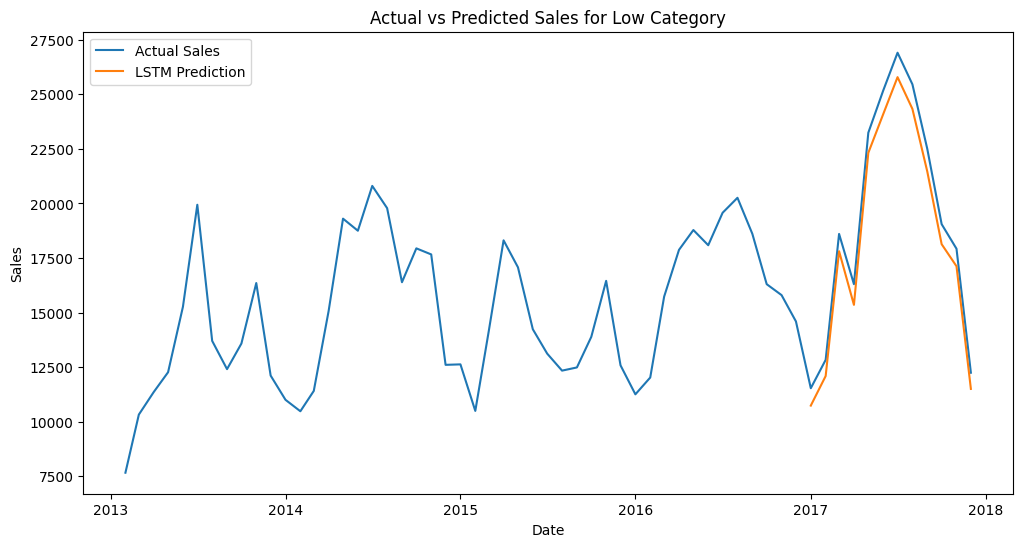

Mid Category - MAE: 1559.5049859347444, MSE: 3638472.378153005, RMSE: 1907.4780151165583, R2: 0.8554713469902517


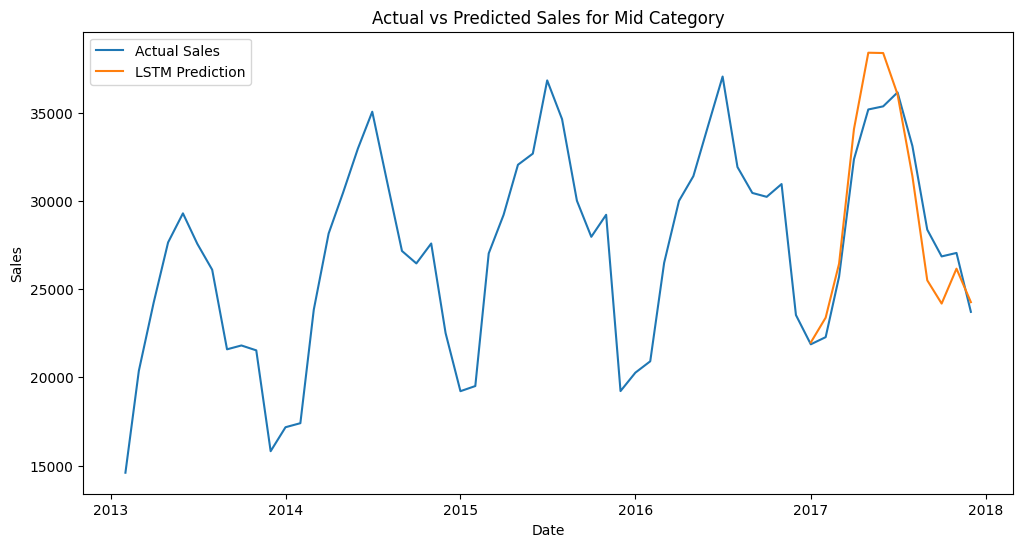

High Category - MAE: 251.8605073878231, MSE: 87644.59134300215, RMSE: 296.0482922480759, R2: 0.9935371607353339


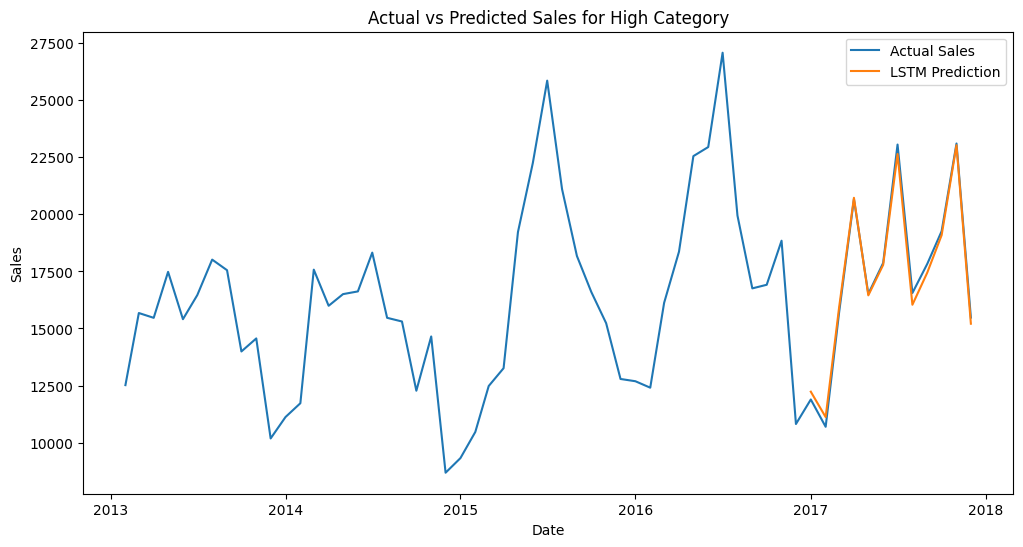

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to evaluate model predictions
def evaluate_predictions(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    return mae, mse, rmse, r2

# Function to plot actual vs predicted sales
def plot_predictions(actual, predicted, category_name):
    plt.figure(figsize=(12, 6))
    plt.plot(actual['date'], actual['sales'], label='Actual Sales')
    plt.plot(predicted['date'], predicted['LSTM Prediction'], label='LSTM Prediction')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Actual vs Predicted Sales for {category_name.capitalize()} Category')
    plt.legend()
    plt.show()

# Evaluate and plot predictions for low category
low_mae, low_mse, low_rmse, low_r2 = evaluate_predictions(low_sales['sales'][-12:], low_predict_df['LSTM Prediction'])
print(f'Low Category - MAE: {low_mae}, MSE: {low_mse}, RMSE: {low_rmse}, R2: {low_r2}')
plot_predictions(low_sales, low_predict_df, 'low')

# Evaluate and plot predictions for mid category
mid_mae, mid_mse, mid_rmse, mid_r2 = evaluate_predictions(mid_sales['sales'][-12:], mid_predict_df['LSTM Prediction'])
print(f'Mid Category - MAE: {mid_mae}, MSE: {mid_mse}, RMSE: {mid_rmse}, R2: {mid_r2}')
plot_predictions(mid_sales, mid_predict_df, 'mid')

# Evaluate and plot predictions for high category
high_mae, high_mse, high_rmse, high_r2 = evaluate_predictions(high_sales['sales'][-12:], high_predict_df['LSTM Prediction'])
print(f'High Category - MAE: {high_mae}, MSE: {high_mse}, RMSE: {high_rmse}, R2: {high_r2}')
plot_predictions(high_sales, high_predict_df, 'high')


In [5]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the models
low_model = load_model('model/best_model_low.keras')
mid_model = load_model('model/best_model_mid.keras')
high_model = load_model('model/best_model_high.keras')

# Function to process and predict future sales for a given category
def predict_future_sales(data, model, window_size, future_periods=12):
    data['date'] = pd.to_datetime(data['date']).dt.to_period("M")
    monthly_sales = data.groupby('date').sum().reset_index()
    monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

    # Calculate sales difference
    monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
    monthly_sales = monthly_sales.dropna()

    # Ensure there is enough data
    if len(monthly_sales) <= window_size:
        raise ValueError(f"Not enough data to process for window size of {window_size}. Available data points: {len(monthly_sales)}.")

    # Prepare supervised data with a window size
    supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)
    for i in range(1, window_size + 1):
        col_name = f'month_{i}'
        supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
    supervised_data = supervised_data.dropna().reset_index(drop=True)

    # Scale the data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(supervised_data)
    last_data = supervised_data[-1:].copy()

    future_predictions = []

    for _ in range(future_periods):
        last_data_scaled = scaler.transform(last_data)
        X_last = last_data_scaled[:, 1:].reshape((1, window_size, 1))
        next_pred = model.predict(X_last)[0, 0]

        future_pred = np.concatenate([[next_pred], last_data_scaled[0, 1:]])
        future_pred = scaler.inverse_transform([future_pred])

        future_predictions.append(future_pred[0][0] + monthly_sales['sales'].iloc[-1])

        new_row = np.append([next_pred], last_data.values[0, :-1])
        last_data = pd.DataFrame([new_row], columns=supervised_data.columns)

    future_dates = pd.date_range(start=monthly_sales['date'].iloc[-1] + pd.DateOffset(months=1), periods=future_periods, freq='M')
    future_df = pd.DataFrame({'date': future_dates, 'LSTM Prediction': future_predictions})

    return future_df

# Load new data
new_data_url = ''
new_data = pd.read_csv(new_data_url)

# Ensure 'date' column is in datetime format
new_data['date'] = pd.to_datetime(new_data['date'])

# Apply categorization
new_data['category'] = new_data['price'].apply(categorize_price)

# Predict future sales for each category
window_size = 6

# Filter data for each category
new_data_low = new_data[new_data['category'] == 'low'].copy()
new_data_mid = new_data[new_data['category'] == 'mid'].copy()
new_data_high = new_data[new_data['category'] == 'high'].copy()

# Predict future sales with sufficient data check
def safe_predict(data, model, category_name):
    try:
        future_df = predict_future_sales(data, model, window_size)
        print(f"Future predictions for {category_name} category:")
        print(future_df)
        plot_future_predictions(future_df, category_name)
    except ValueError as e:
        print(f"Skipping {category_name} category: {e}")

safe_predict(new_data_low, low_model, 'low')
safe_predict(new_data_mid, mid_model, 'mid')
safe_predict(new_data_high, high_model, 'high')


Skipping low category: Not enough data to process for window size of 6. Available data points: 0.
Skipping mid category: Not enough data to process for window size of 6. Available data points: 0.
Skipping high category: Not enough data to process for window size of 6. Available data points: 0.
